# Model: Random Forest with all the columns and hyperparmeters optimisation

In this notebook, all the training/predictions steps are implemented for a very basic model (random forest with all the features). 
The goal is to get the best f1-score ! May the force be with you 🧨🧨  

# Import libraries

In [9]:
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score,precision_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

import optuna
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display

# Read file with labels

In [10]:
data = pd.read_csv('../data/processed/conversion_data_train_EDA_output.csv', index_col=0)
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284578, 9)


In [11]:
data.head()

,country,age,new_user,source,total_pages_visited,converted,total_pages_visited_x2,total_pages_visited_age,total_pages_visited_age_x2
0,China,22,1,Direct,2,0,4,44,1936
1,UK,21,1,Ads,3,0,9,63,3969
2,Germany,20,0,Seo,14,1,196,280,78400
3,US,23,1,Seo,3,0,9,69,4761
4,US,28,1,Direct,3,0,9,84,7056


# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [12]:
target_variable = 'converted'
X = data.drop(columns=[target_variable])
Y = data.loc[:, target_variable]
print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'total_pages_visited_x2', 'total_pages_visited_age',
       'total_pages_visited_age_x2'],
      dtype='object')



In [13]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=925662591, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [14]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

# Create pipeline for numeric features
display(X.select_dtypes(exclude='object') )
numeric_features = X.select_dtypes(exclude='object').columns  # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(
    steps=[
        (
            "scaler", 
            StandardScaler()
        ),
    ]
)

display(X.select_dtypes(include='object') )

# Create pipeline for categorical features
categorical_features = X.select_dtypes(include='object').columns  # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(drop="first"),
        ),  # first column will be dropped to avoid creating correlations between features
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
print("...Done.")
print(
    X_train[0:5]
)  # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

Encoding categorical features and standardizing numerical features...


,age,new_user,total_pages_visited,total_pages_visited_x2,total_pages_visited_age,total_pages_visited_age_x2
0,22,1,2,4,44,1936
1,21,1,3,9,63,3969
2,20,0,14,196,280,78400
3,23,1,3,9,69,4761
4,28,1,3,9,84,7056
...,...,...,...,...,...,...
284575,36,1,1,1,36,1296
284576,31,1,2,4,62,3844
284577,41,1,5,25,205,42025
284578,31,1,4,16,124,15376


,country,source
0,China,Direct
1,UK,Ads
2,Germany,Seo
3,US,Seo
4,US,Direct
...,...,...
284575,US,Ads
284576,US,Seo
284577,US,Seo
284578,US,Direct


Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited  \
141530      UK   35         0     Seo                    4   
106919      US   20         1  Direct                    2   
22695       US   51         0     Ads                    1   
97132       US   43         1     Ads                    3   
262631   China   26         1     Seo                    1   

        total_pages_visited_x2  total_pages_visited_age  \
141530                      16                      140   
106919                       4                       40   
22695                        1                       51   
97132                        9                      129   
262631                       1                       26   

        total_pages_visited_age_x2  
141530                       19600  
106919                        1600  
22695                         2601  
97132                        16641  
262631                         676  
...Done.

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold # Use StratifiedKFold for classification!
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score # Import necessary metrics
import numpy as np
import pandas as pd # Assuming scores_df is a pandas DataFrame

# --- 1. RandomForestClassifier with Optuna (Optimizing for F1-Score) ---
print("Optimizing RandomForestClassifier with Optuna...")

def objective_rf(trial):
    max_depth = trial.suggest_int('max_depth', 7, 12)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 8, 25)
    min_samples_split = trial.suggest_int('min_samples_split', 15, 40)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    max_features_choice = trial.suggest_float('max_features', 0.1, 0.5)
    # Consider adding class_weight for imbalanced datasets and F1 optimization
    class_weight_choice = trial.suggest_categorical('class_weight', [None, 'balanced'])


    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        max_features=max_features_choice,
        class_weight=class_weight_choice,
        random_state=42,
        n_jobs=-1 # Ensure n_jobs is -1 for the model too, if not already handled by cross_val_score
    )

    # IMPORTANT: Use StratifiedKFold for classification and F1-score
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Store scores from each fold to report to Optuna
    fold_f1_scores = []

    # Access underlying NumPy arrays for indexing
    # This is the key change to resolve KeyError
    X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    Y_train_np = Y_train.values if isinstance(Y_train, pd.Series) else Y_train

    # Manual cross-validation loop to report intermediate scores
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_np, Y_train_np)):
        X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
        Y_train_fold, Y_val_fold = Y_train_np[train_idx], Y_train_np[val_idx]

        model.fit(X_train_fold, Y_train_fold)
        
        # Predict on the validation set for this fold
        Y_val_pred = model.predict(X_val_fold)
        
        # Calculate F1-score for the current fold
        # Use 'weighted' or 'macro' for multi-class, 'binary' for binary classification
        current_f1 = f1_score(Y_val_fold, Y_val_pred, average='binary') # Or 'macro', 'binary'

        fold_f1_scores.append(current_f1)

        # Report the current cumulative mean F1-score to Optuna
        # The 'step' here is the fold index
        trial.report(np.mean(fold_f1_scores), fold_idx)

        # Check if the trial should be pruned after this fold
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Return the average F1-score across all folds
    return np.mean(fold_f1_scores)

# Create a study object with a pruner
# MedianPruner is a good general-purpose pruner.
# It prunes trials whose intermediate objective values are worse than the median of the values
# of the trials that have completed the same step.
study_rf = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(
    n_startup_trials=5, # Number of trials to run without pruning
    n_warmup_steps=0,   # Number of intermediate reports to wait for before starting pruning
    interval_steps=1    # Check for pruning at every 'interval_steps' intermediate reports
))

# You might increase n_trials further with pruning enabled, as it can save time on bad trials
study_rf.optimize(objective_rf, n_trials=150) 

print("Best hyperparameters (RandomForest): ", study_rf.best_params)
print("Best validation F1-score (RandomForest): ", study_rf.best_value)

# Train the best RandomForest model
# Ensure 'random_state' is passed, and potentially 'n_jobs' if not in best_params
best_rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train, Y_train)

[I 2025-06-09 21:00:10,729] A new study created in memory with name: no-name-a8633365-e1f7-4213-ae7a-73a0b5385a9f


Optimizing RandomForestClassifier with Optuna...


[I 2025-06-09 21:01:25,408] Trial 0 finished with value: 0.748191293646835 and parameters: {'max_depth': 11, 'min_samples_leaf': 20, 'min_samples_split': 15, 'n_estimators': 1056, 'max_features': 0.42279365859431284, 'class_weight': None}. Best is trial 0 with value: 0.748191293646835.


In [ ]:

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_contour,
    plot_intermediate_values # Often useful when using pruning
)
import matplotlib.pyplot as plt # For showing plots if you're not in an interactive environment

# --- Assuming 'study_rf' is your Optuna Study object after optimization ---
# (Make sure you've run study_rf.optimize() before trying to plot)

print("Generating Optuna Visualization Plots...")

# 1. Plot Optimization History
# Shows how the objective value (F1-score in your case) changed over trials.
# You can see if the optimization is converging or if there's still potential for improvement.
fig_history = plot_optimization_history(study_rf)
fig_history.show() # For interactive Plotly plot (e.g., in Jupyter notebooks)
# If running in a script and you want to save/show with Matplotlib:
# fig_history.write_image("optimization_history.png") # Requires kaleido: pip install kaleido
# plt.figure(figsize=(10, 6)) # Matplotlib alternative (less interactive)
# plt.title("Optimization History")
# plt.xlabel("Trial")
# plt.ylabel("F1-score")
# plt.plot([t.value for t in study_rf.trials])
# plt.grid(True)
# plt.show()


# 2. Plot Parameter Importances
# Shows which hyperparameters were most influential in determining the objective value.
# This helps you understand which parameters had the biggest impact on your F1-score.
fig_importances = plot_param_importances(study_rf)
fig_importances.show()
# fig_importances.write_image("parameter_importances.png") # Requires kaleido


# 3. Plot Slice
# Shows the relationship between a single hyperparameter and the objective value.
# Each dot represents a trial. Useful for seeing trends for individual parameters.
fig_slice = plot_slice(study_rf)
fig_slice.show()
# fig_slice.write_image("slice_plot.png") # Requires kaleido


# 4. Plot Contour
# Shows the relationship between two hyperparameters and the objective value using a contour plot.
# This is useful for identifying interactions between two parameters.
# You need to specify which two parameters you want to visualize.
# For example, let's look at 'max_depth' and 'n_estimators'.
# Ensure the chosen parameters are floats or integers.
# 'max_features' is a float, others are ints, so they are compatible.
fig_contour = plot_contour(study_rf, params=['max_depth', 'n_estimators'])
fig_contour.show()
# fig_contour.write_image("contour_plot_max_depth_n_estimators.png") # Requires kaleido

# You can plot other combinations as well:
# fig_contour_2 = plot_contour(study_rf, params=['max_depth', 'max_features'])
# fig_contour_2.show()

# 5. Plot Intermediate Values (Useful when using pruning)
# If you implemented pruning, this plot can show you how trials were pruned.
# It plots the intermediate objective values reported by trial.report() for each trial.
# Trials that were pruned will stop abruptly.
try:
    fig_intermediate = plot_intermediate_values(study_rf)
    fig_intermediate.show()
    # fig_intermediate.write_image("intermediate_values.png") # Requires kaleido
except Exception as e:
    print(f"Could not plot intermediate values, might not have enough data: {e}")


print("Plot generation complete. If running in a non-interactive environment, save the figures.")


Generating Optuna Visualization Plots...


Plot generation complete. If running in a non-interactive environment, save the figures.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = best_rf_model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [ ]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(
    X_test
)  # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done.")
print(
    X_test[0:5, :]
)  # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Encoding categorical features and standardizing numerical features...
Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited  \
60969    China   35         0     Seo                    4   
375      China   27         0     Seo                    9   
92712       US   26         1     Ads                   11   
68129       US   19         1     Ads                    5   
190999   China   41         0  Direct                    5   

        total_pages_visited_x2  total_pages_visited_age  \
60969                       16                      140   
375                         81                      243   
92712                      121                      286   
68129                       25                       95   
190999                      25                      205   

        total_pages_visited_age_x2  
60969                        19600  
375                          59049  
92712                        81796  
68129        

In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = best_rf_model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 1]



## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7633946664505147
f1-score on test set :  0.739847403396505


f1-score on train set :  0.768017471487503
f1-score on test set :  0.7501521236460995

In [ ]:
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test,Y_test_pred))
print()

print("recall-score on training set: ", recall_score(Y_train, Y_train_pred))
print("recall-score on training set: ", recall_score(Y_test, Y_test_pred))
print()

print("precision-score on training set: ", precision_score(Y_train, Y_train_pred))
print("precision-score on test set: ", precision_score(Y_test, Y_test_pred))

accuracy on training set :  0.9863235769538918
accuracy on test set :  0.985143017780589

f1-score on training set :  0.7633946664505147
f1-score on test set :  0.739847403396505

recall-score on training set:  0.6841493534795874
recall-score on training set:  0.6549019607843137

precision-score on training set:  0.8634030069673634
precision-score on test set:  0.8501131221719457


In [ ]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[205805    745]
 [  2174   4709]]

Confusion matrix on test set : 
[[68585   265]
 [  792  1503]]



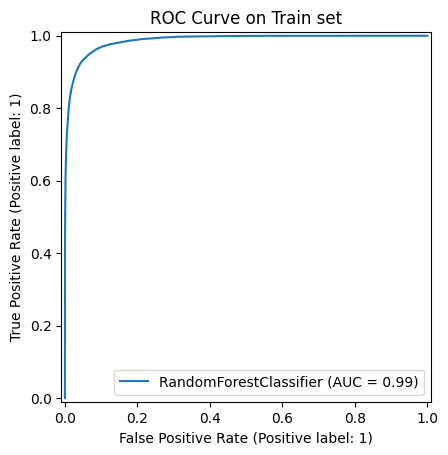

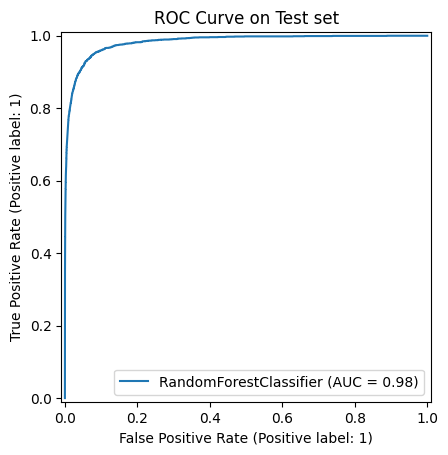

In [ ]:
_, ax = plt.subplots()
ax.set(
    title="ROC Curve on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    best_rf_model, X_train, Y_train, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    best_rf_model, X_test, Y_test, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

best_rf_model.fit(X,Y)

RandomForestClassifier(max_depth=10, max_features=0.17367536997373756,
                       min_samples_leaf=14, min_samples_split=23,
                       n_estimators=1984, n_jobs=-1, random_state=42)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('../data/raw/conversion_data_test.csv')
data_without_labels['total_pages_visited_x2'] = data_without_labels['total_pages_visited'] ** 2
# data_without_labels['total_pages_visited_x3'] = data_without_labels['total_pages_visited'] ** 3
data_without_labels['total_pages_visited_age'] = data_without_labels['total_pages_visited'] * data_without_labels['age']
data_without_labels['total_pages_visited_age_x2'] = (data_without_labels['total_pages_visited'] * data_without_labels['age']) ** 2 
# data_without_labels['total_pages_visited_log'] = data_without_labels['total_pages_visited'].apply(np.log10)
print('Prediction set (without labels) :', data_without_labels.shape)

print(data_without_labels.head())

Prediction set (without labels) : (31620, 8)
  country  age  new_user  source  total_pages_visited  total_pages_visited_x2  \
0      UK   28         0     Seo                   16                     256   
1      UK   22         1  Direct                    5                      25   
2   China   32         1     Seo                    1                       1   
3      US   32         1     Ads                    6                      36   
4   China   25         0     Seo                    3                       9   

   total_pages_visited_age  total_pages_visited_age_x2  
0                      448                      200704  
1                      110                       12100  
2                       32                        1024  
3                      192                       36864  
4                       75                        5625  


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(data_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.3097583  -1.47733786  3.32395597  4.19158057  2.7801515   3.08873447
   0.          1.          0.          0.          1.        ]
 [-1.03656638  0.67689324  0.03646155 -0.18947954 -0.3502687  -0.39550037
   0.          1.          0.          1.          0.        ]
 [ 0.17478042  0.67689324 -1.15899097 -0.64465462 -1.07267336 -0.60011631
   0.          0.          0.          0.          1.        ]
 [ 0.17478042  0.67689324  0.33532467  0.01914237  0.40918236  0.06198511
   0.          0.          1.          0.          0.        ]
 [-0.67316234 -1.47733786 -0.56126471 -0.49292959 -0.67442463 -0.5151183
   0.          0.          0.          0.          1.        ]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': best_rf_model.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('../data/processed/conversion_data_test_predictions_Nicolas-Optuna-Random-Forest-fe.csv', index=False)
